# Data Preprocessing
# Data Cleaning

In [37]:
import pandas as pd

matches_data = pd.read_csv("ipl_matches.csv")
batting_data = pd.read_csv("ipl_batting_data.csv")
bowling_data = pd.read_csv("ipl_bowling_data.csv")

# 1. **Handle Missing Data in Batting Data**
# Fill missing Runs, Balls, 4s, 6s, SR with 0 where applicable
batting_data['Runs'] = batting_data['Runs'].fillna(0)
batting_data['Balls'] = batting_data['Balls'].fillna(0)
batting_data['4s'] = batting_data['4s'].fillna(0)
batting_data['6s'] = batting_data['6s'].fillna(0)
batting_data['SR'] = batting_data['SR'].fillna(0)

# Fill missing Wicket_Taker with "Not applicable" for cases where player was not dismissed
batting_data['Wicket_Taker'] = batting_data['Wicket_Taker'].fillna('Not applicable')

# 2. **Handle Missing Data in Match Data**
# Fill missing Season values with a default season (e.g., 2008 for historical consistency)
matches_data['Season'] = matches_data['Season'].fillna(2008)

# Fill missing Winner and Margin values by either inferring or setting them as "Unknown"
matches_data['Winner'] = matches_data['Winner'].fillna('Unknown')
matches_data['Margin'] = matches_data['Margin'].fillna('Unknown')

# 3. **Convert Data Types**
# Convert Date columns to datetime type
batting_data['Date'] = pd.to_datetime(batting_data['Date'])
bowling_data['Date'] = pd.to_datetime(bowling_data['Date'])
matches_data['Date'] = pd.to_datetime(matches_data['Date'])

# Convert relevant columns to correct types
batting_data['MatchID'] = batting_data['MatchID'].astype(int)
bowling_data['MatchID'] = bowling_data['MatchID'].astype(int)
matches_data['ID'] = matches_data['ID'].astype(int)

# Verify the changes
print("Batting Data Info After Cleaning:")
print(batting_data.info())
print("\nMatch Data Info After Cleaning:")
print(matches_data.info())
print("\nBowling Data Info After Cleaning:")
print(bowling_data.info())

batting_data.to_csv('cleaned_batting_data.csv', index=False)
bowling_data.to_csv('cleaned_bowling_data.csv', index=False)
matches_data.to_csv('cleaned_match_data.csv', index=False)

Batting Data Info After Cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17130 entries, 0 to 17129
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Player        17130 non-null  object        
 1   Runs          17130 non-null  object        
 2   Balls         17130 non-null  object        
 3   4s            17130 non-null  object        
 4   6s            17130 non-null  object        
 5   SR            17130 non-null  object        
 6   Dismissal     17130 non-null  object        
 7   Wicket_Taker  17130 non-null  object        
 8   MatchID       17130 non-null  int32         
 9   Team          17130 non-null  object        
 10  Match         17130 non-null  object        
 11  Date          17130 non-null  datetime64[ns]
 12  Teams         17130 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(11)
memory usage: 1.6+ MB
None

Match Data Info After Cleaning:

In [20]:
import pandas as pd
import re

# Load CSV with the first row as header
df = pd.read_csv('cleaned_batting_data.csv')

# Drop rows that are completely empty
df = df.dropna(how='all')

# Keep the header safely
columns = df.columns

# Check for unwanted rows (those with 'BOWLING' in the 'Player' column)
# But make sure we don't touch the header
if 'Player' in columns:
    # Filter only if 'Player' column exists
    df = df[~df['Player'].astype(str).str.contains('BOWLING', na=False)]

# Clean weird symbols ONLY in data, NOT in headers
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].apply(lambda x: re.sub(r'[^A-Za-z0-9\s\.\-]', '', str(x)) if pd.notnull(x) else x)

# Restore original column names if anything changed
df.columns = columns

# Save cleaned dataset
df.to_csv('cleaned_batting_data.csv', index=False)
print("Batting data cleaned")


Batting data cleaned


# Data Visualization

## Batting

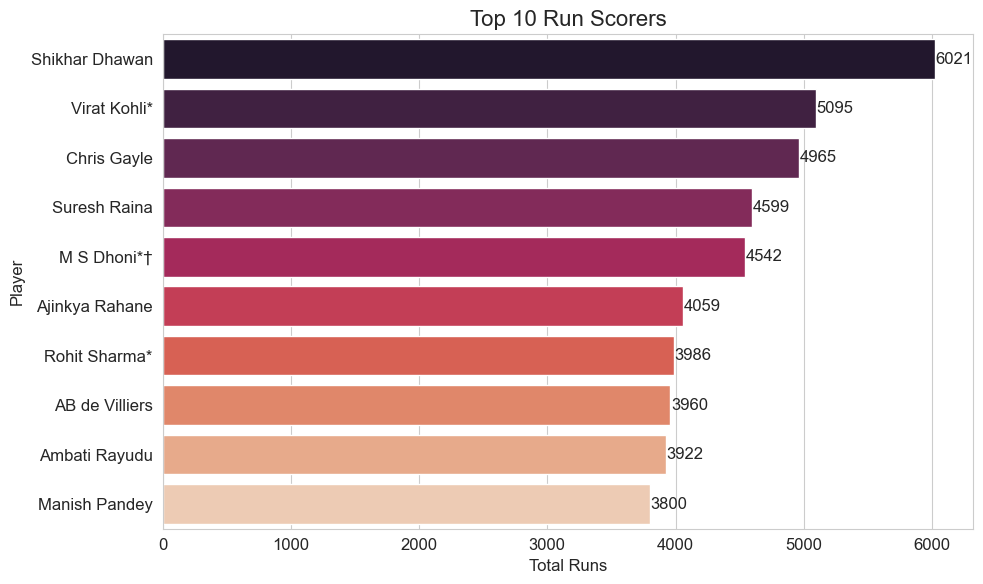

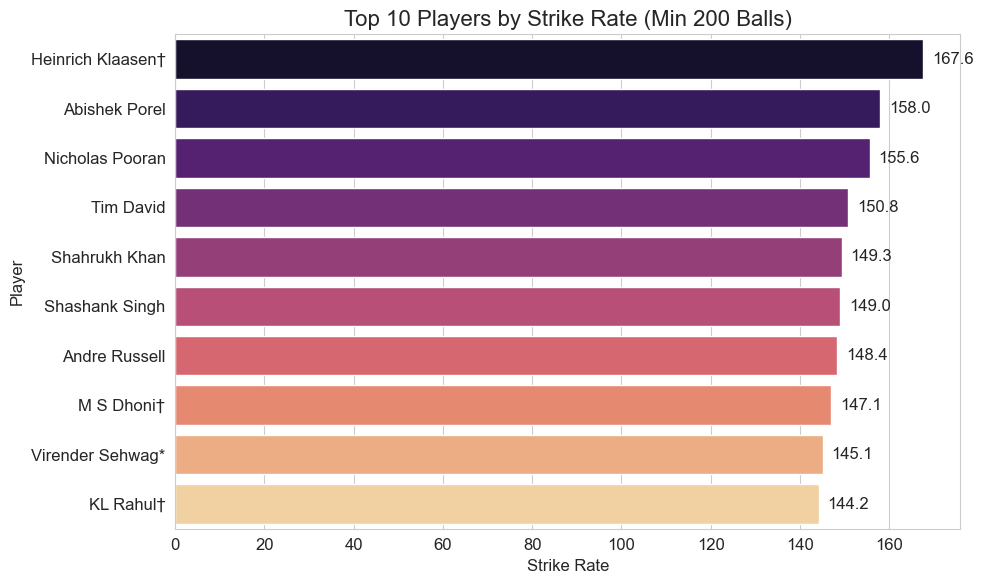

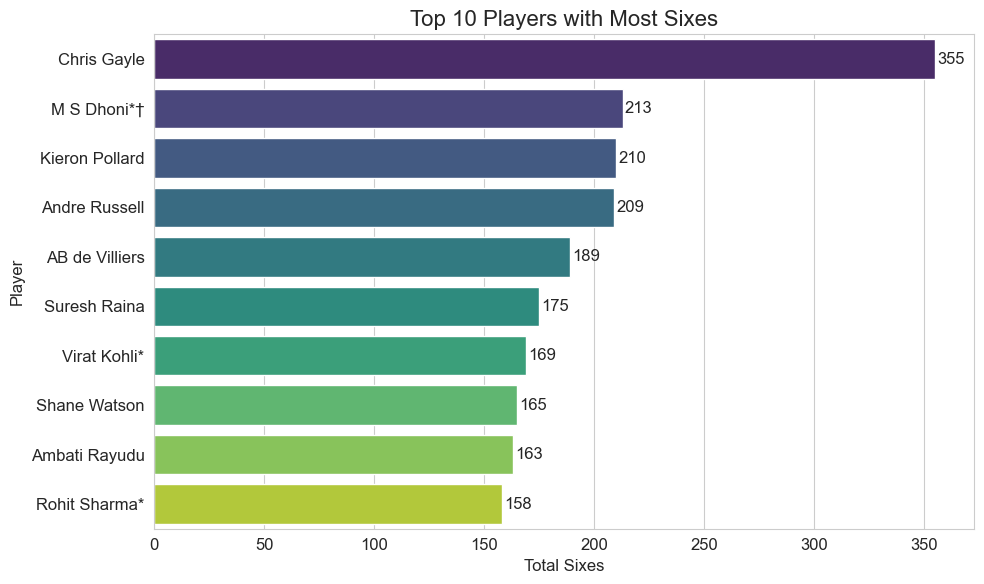

In [40]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your cleaned batting data
batting_df = pd.read_csv('cleaned_batting_data.csv')

# Convert 'Runs' and 'Balls' to numeric (handle non-numeric like "DNB", "TDNB" if any)
batting_df['Runs'] = pd.to_numeric(batting_df['Runs'], errors='coerce')
batting_df['Balls'] = pd.to_numeric(batting_df['Balls'], errors='coerce')

# Drop NaN entries for meaningful stats
batting_df = batting_df.dropna(subset=['Runs', 'Balls'])

# =============== 1. Top 10 Run Scorers ===============
top_run_scorers = batting_df.groupby('Player')['Runs'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
bars = sns.barplot(
    x=top_run_scorers.values,
    y=top_run_scorers.index,
    hue=top_run_scorers.index,
    palette='rocket',
    dodge=False,
    legend=False
)
# Add numbers on bars
for bar in bars.patches:
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center')

plt.title('Top 10 Run Scorers', fontsize=16)
plt.xlabel('Total Runs')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# =============== 2. Top 10 Players by Strike Rate (min 200 balls) ===============
# Calculate Strike Rate
batting_df['Strike_Rate'] = (batting_df['Runs'] / batting_df['Balls']) * 100

# Filter players who have faced at least 200 balls
balls_faced = batting_df.groupby('Player')['Balls'].sum()
eligible_players = balls_faced[balls_faced >= 200].index

# Calculate average strike rate
avg_sr = batting_df[batting_df['Player'].isin(eligible_players)].groupby('Player')['Strike_Rate'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
bars = sns.barplot(
    x=avg_sr.values,
    y=avg_sr.index,
    hue=avg_sr.index,
    palette='magma',
    dodge=False,
    legend=False
)
# Add numbers on bars
for bar in bars.patches:
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.1f}', va='center')

plt.title('Top 10 Players by Strike Rate (Min 200 Balls)', fontsize=16)
plt.xlabel('Strike Rate')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# =============== 3. Most 6s Hit ===============
# Convert 6s to numeric
batting_df['6s'] = pd.to_numeric(batting_df['6s'], errors='coerce')

top_six_hitters = batting_df.groupby('Player')['6s'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
bars = sns.barplot(
    x=top_six_hitters.values,
    y=top_six_hitters.index,
    hue=top_six_hitters.index,
    palette='viridis',
    dodge=False,
    legend=False
)
# Add numbers on bars
for bar in bars.patches:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center')

plt.title('Top 10 Players with Most Sixes', fontsize=16)
plt.xlabel('Total Sixes')
plt.ylabel('Player')
plt.tight_layout()
plt.show()


## Bowling


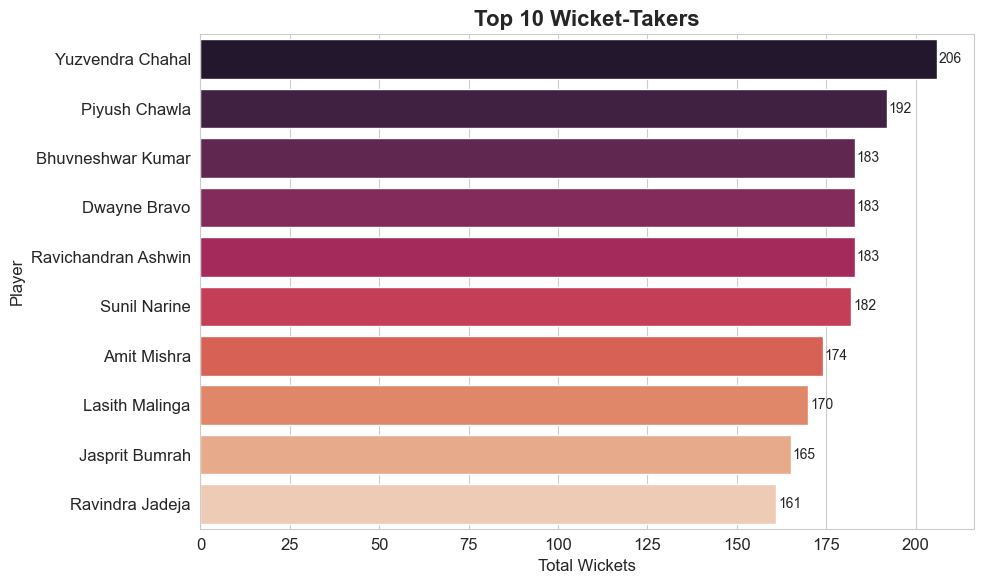

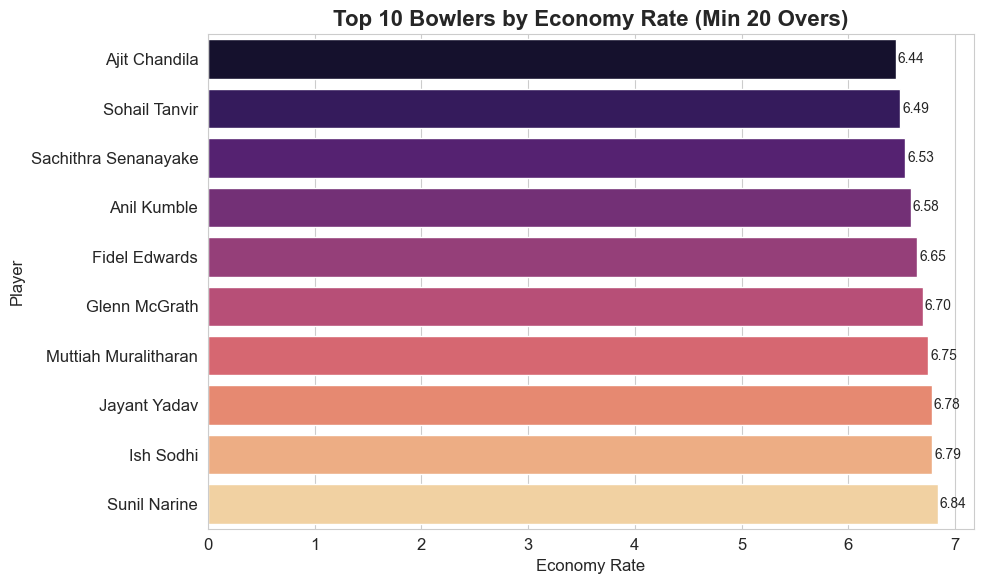

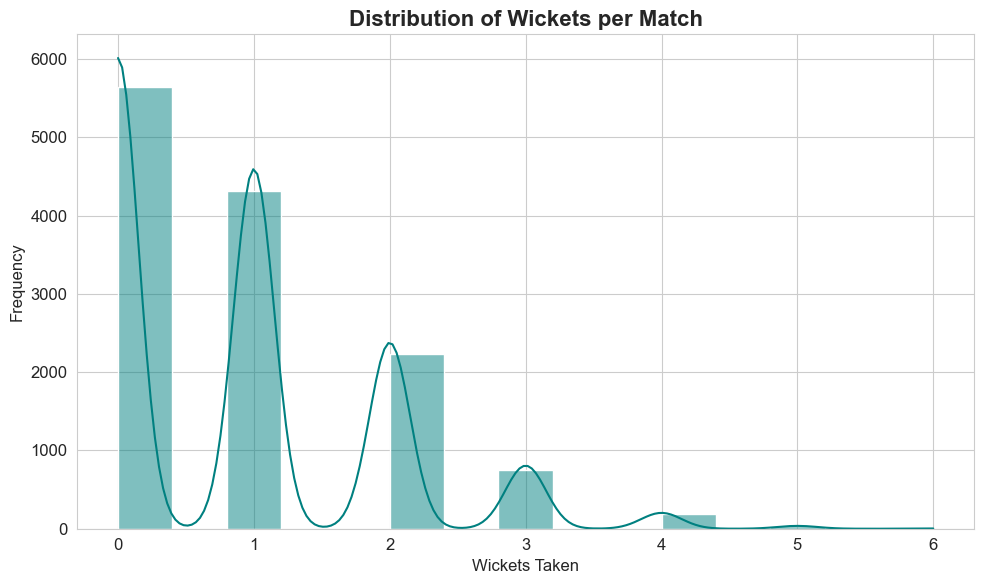

In [39]:
# --- Import Libraries ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and Prepare Data ---
bowling_df = pd.read_csv('cleaned_bowling_data.csv')

# Ensure numeric columns
numeric_cols = ['Wickets', 'Runs', 'Overs', 'ER']
for col in numeric_cols:
    bowling_df[col] = pd.to_numeric(bowling_df[col], errors='coerce')

# Drop rows with missing essential data
bowling_df.dropna(subset=['Wickets', 'Runs', 'Overs'], inplace=True)

# Set common seaborn style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# --- Important Correction: Aggregate per Player per Match ---
# Check if there is a match identifier column
if 'Match_ID' in bowling_df.columns:
    # Aggregate Wickets per Player per Match
    player_match_wickets = bowling_df.groupby(['Player', 'Match_ID'])['Wickets'].sum().reset_index()
else:
    # If no match info, assume per-row is per match (bad but fallback)
    player_match_wickets = bowling_df[['Player', 'Wickets']]

# Now group total wickets per player properly
top_wicket_takers = player_match_wickets.groupby('Player')['Wickets'].sum().sort_values(ascending=False).head(10)

# --- 1. Top 10 Wicket-Takers ---
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    x=top_wicket_takers.values,
    y=top_wicket_takers.index,
    hue=top_wicket_takers.index,
    palette='rocket',
    dodge=False,
    legend=False
)
# Add value labels
for bar in bars.patches:
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height()/2,
        f'{int(bar.get_width())}',
        ha='left', va='center', fontsize=10
    )

plt.title('Top 10 Wicket-Takers', fontsize=16, weight='bold')
plt.xlabel('Total Wickets')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# --- 2. Best Economy Rates (Minimum 20 Overs Bowled) ---
# Filter bowlers with minimum overs
overs_bowled = bowling_df.groupby('Player')['Overs'].sum()
eligible_bowlers = overs_bowled[overs_bowled >= 20].index

# Calculate average economy rate
avg_er = bowling_df[bowling_df['Player'].isin(eligible_bowlers)] \
            .groupby('Player')['ER'].mean().sort_values().head(10)

plt.figure(figsize=(10, 6))
bars = sns.barplot(
    x=avg_er.values,
    y=avg_er.index,
    hue=avg_er.index,
    palette='magma',
    dodge=False,
    legend=False
)

# Add value labels
for bar in bars.patches:
    plt.text(
        bar.get_width() + 0.02,
        bar.get_y() + bar.get_height()/2,
        f'{bar.get_width():.2f}',
        ha='left', va='center', fontsize=10
    )

plt.title('Top 10 Bowlers by Economy Rate (Min 20 Overs)', fontsize=16, weight='bold')
plt.xlabel('Economy Rate')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# --- 3. Distribution of Wickets per Match ---
plt.figure(figsize=(10, 6))
sns.histplot(
    bowling_df['Wickets'],
    bins=15,
    kde=True,
    color='teal'
)

plt.title('Distribution of Wickets per Match', fontsize=16, weight='bold')
plt.xlabel('Wickets Taken')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



## Match

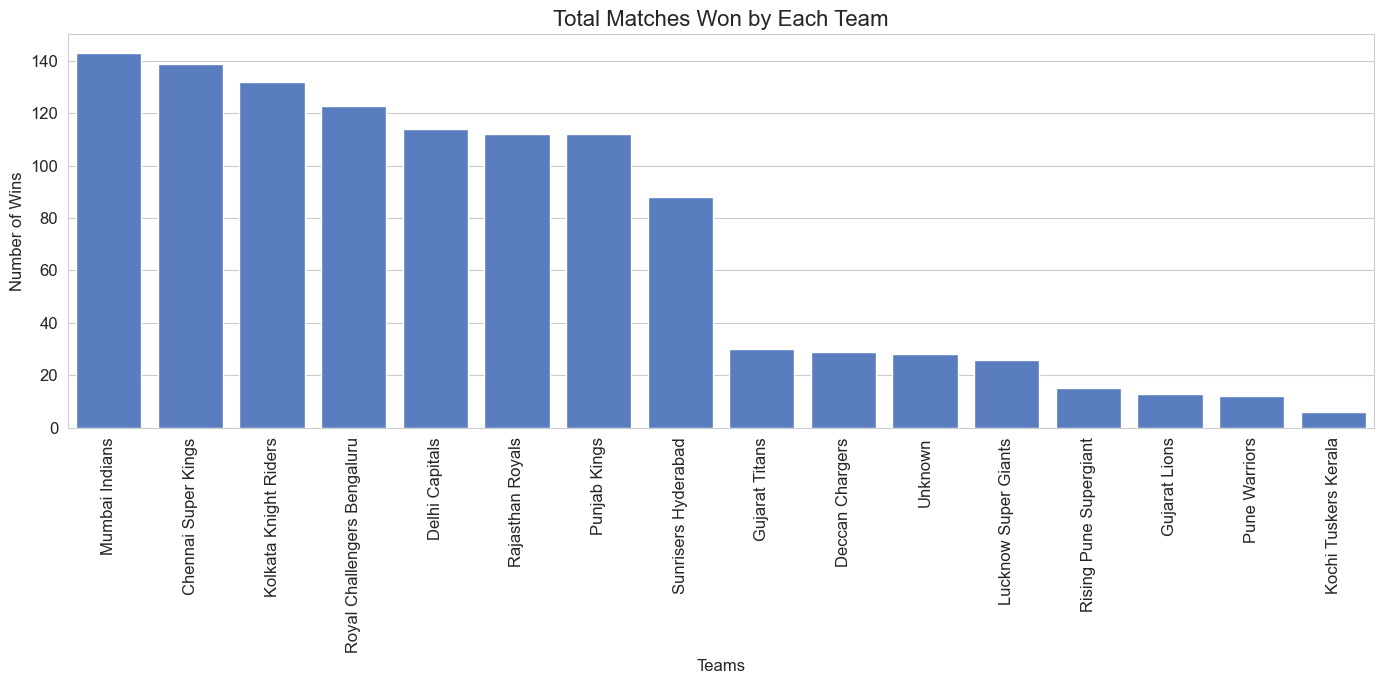

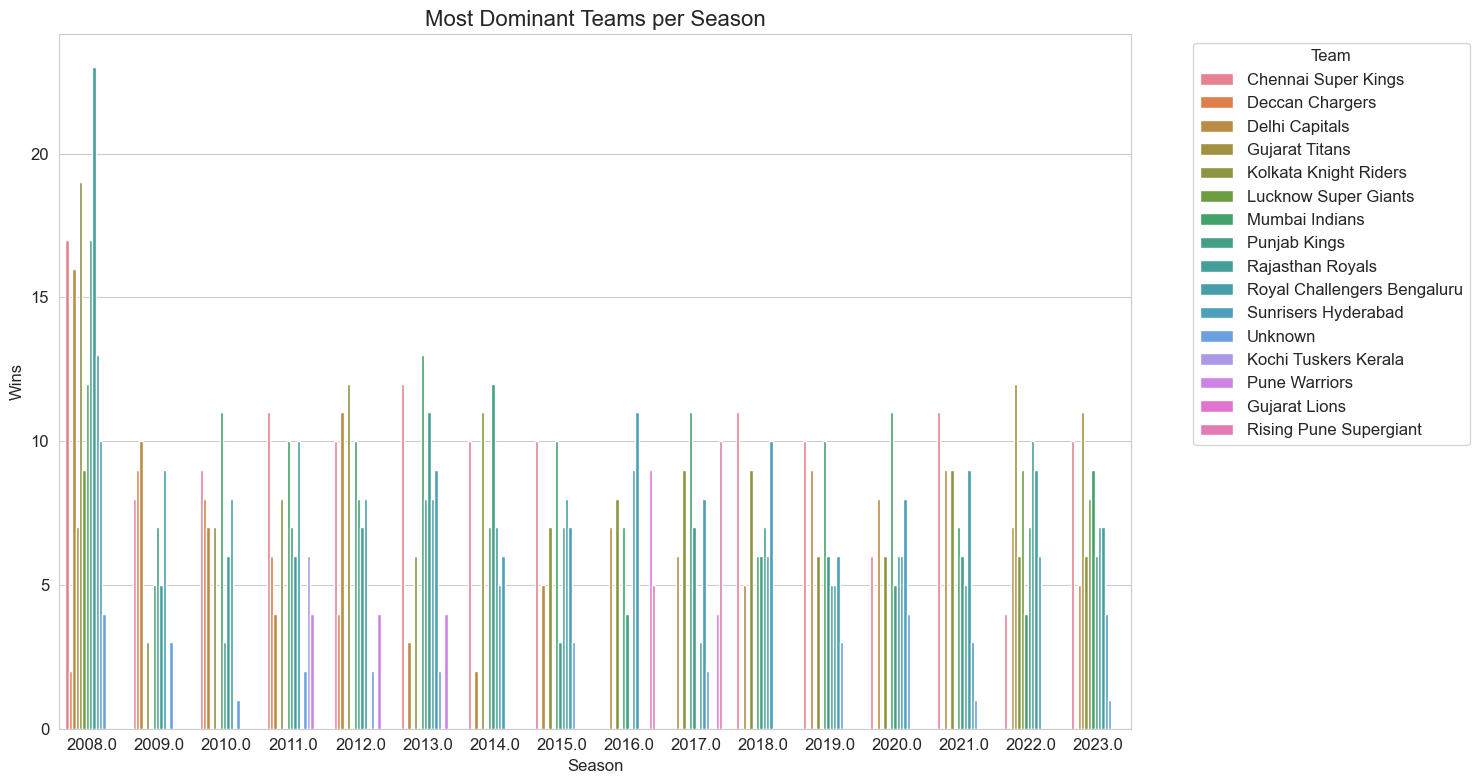

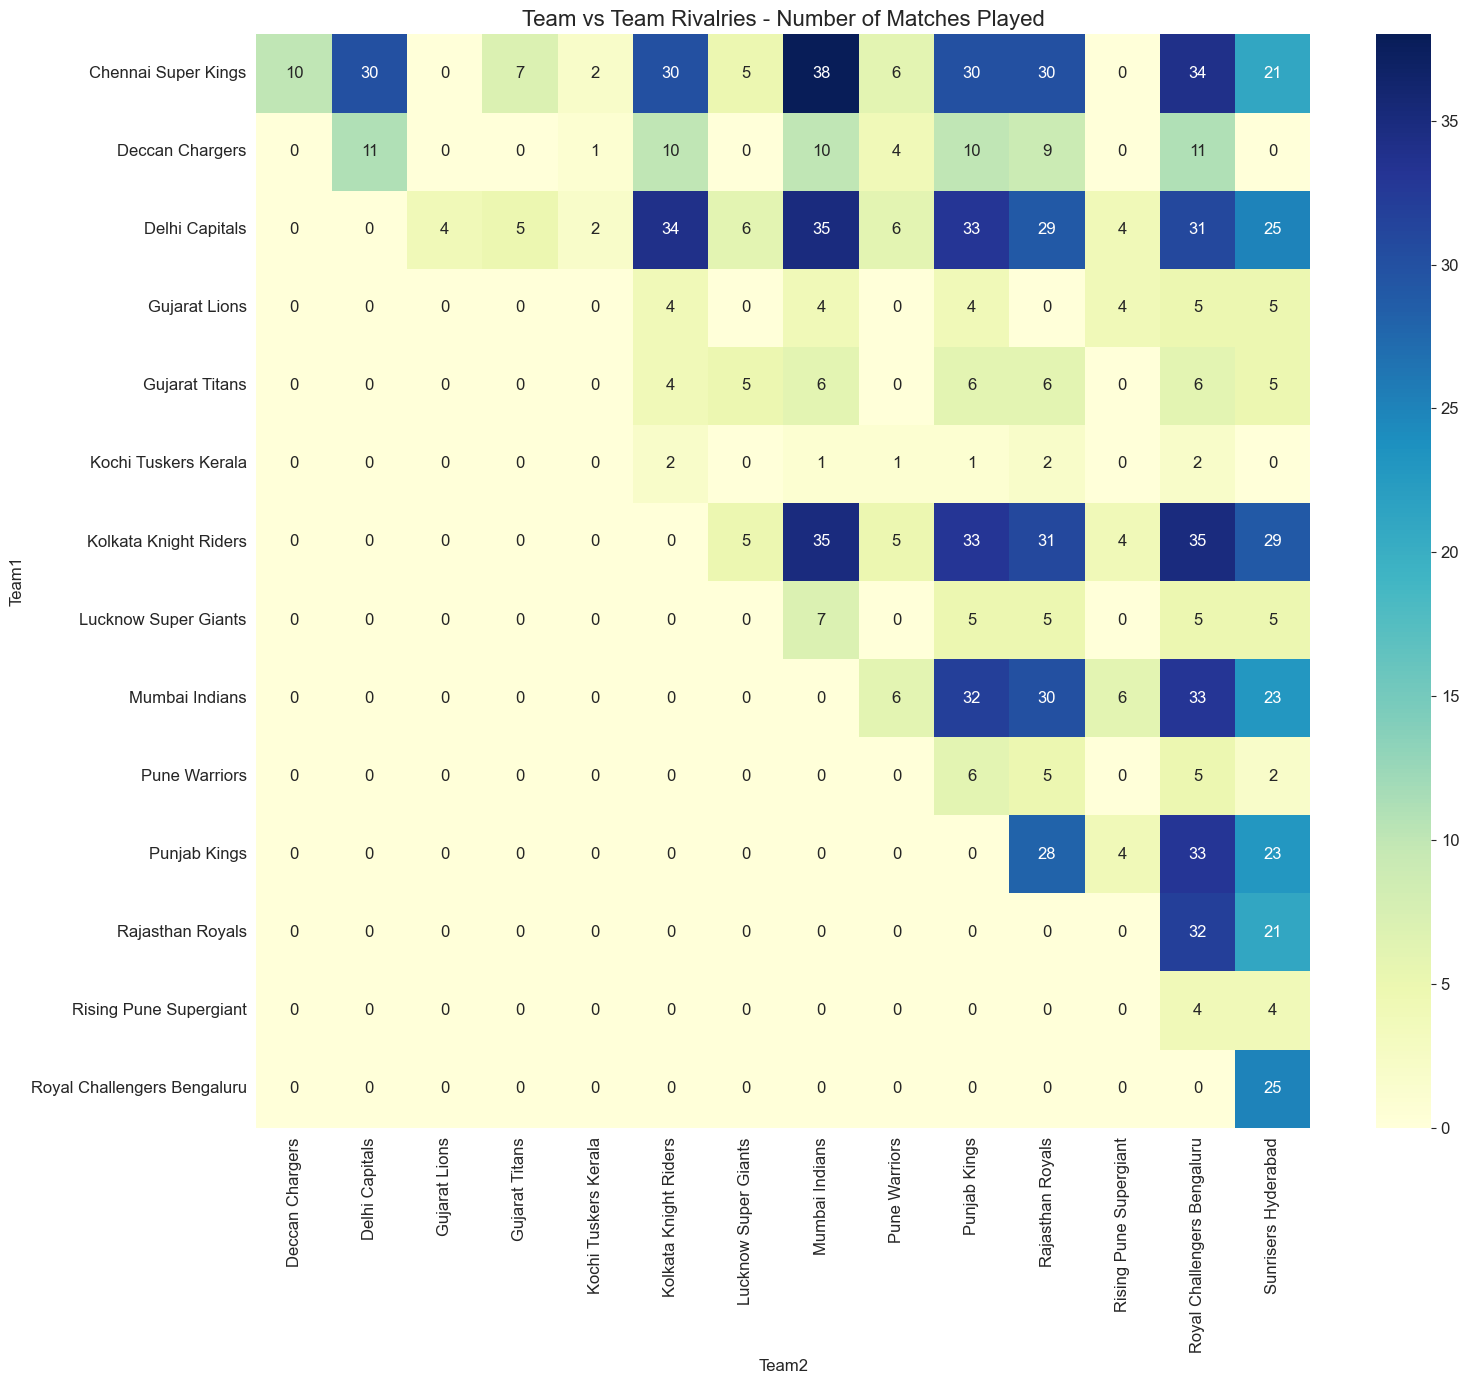

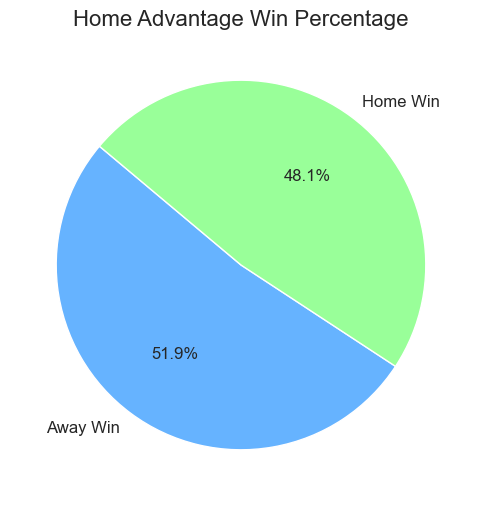

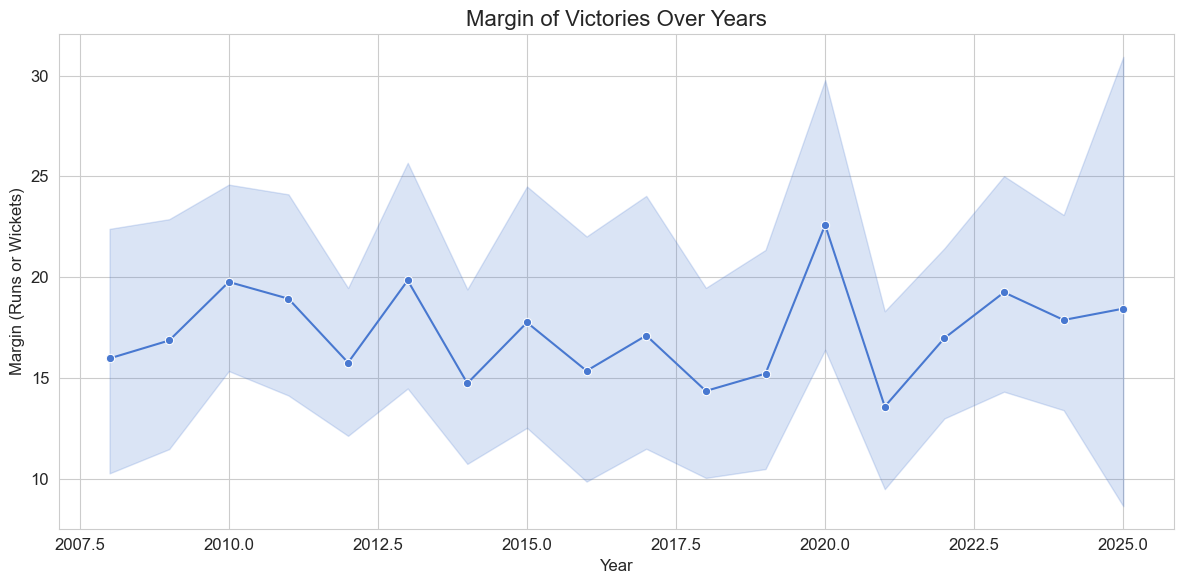

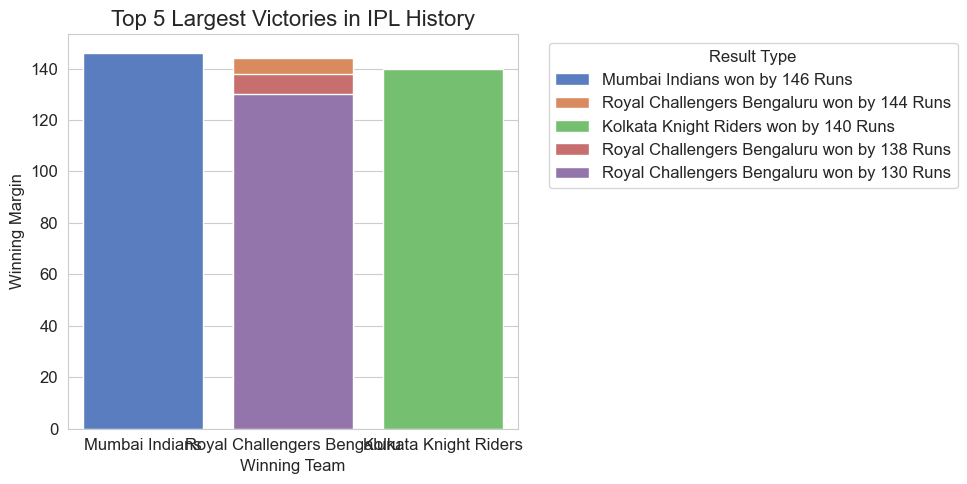

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme
sns.set_style('whitegrid')
sns.set_palette('muted')

# Load Data
df = pd.read_csv('cleaned_match_data.csv')

# Convert Date column to datetime and extract Year
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df['Year'] = df['Date'].dt.year

# 1. Number of Matches Won by Each Team
plt.figure(figsize=(14,7))
team_wins = df['Winner'].value_counts()
sns.barplot(x=team_wins.index, y=team_wins.values)
plt.xticks(rotation=90)
plt.title('Total Matches Won by Each Team', fontsize=16)
plt.xlabel('Teams')
plt.ylabel('Number of Wins')
plt.tight_layout()
plt.show()

# 2. Most Dominant Team per Season
dominant_team = df.groupby(['Season', 'Winner']).size().reset_index(name='Wins')
plt.figure(figsize=(15,8))
sns.barplot(x='Season', y='Wins', hue='Winner', data=dominant_team)
plt.title('Most Dominant Teams per Season', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Wins')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Team vs Team Rivalries Heatmap
df['team_pair'] = df.apply(lambda x: tuple(sorted([x['Team1'], x['Team2']])), axis=1)
rivalry = df['team_pair'].value_counts().reset_index(name='Matches')
rivalry[['Team1', 'Team2']] = pd.DataFrame(rivalry['team_pair'].tolist(), index=rivalry.index)
pivot_rivalry = rivalry.pivot(index='Team1', columns='Team2', values='Matches').fillna(0)

plt.figure(figsize=(16,14))
sns.heatmap(pivot_rivalry, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Team vs Team Rivalries - Number of Matches Played', fontsize=16)
plt.tight_layout()
plt.show()

# 4. Home Advantage Analysis (Simple Logic: Team1 as Home)
df['Home_Win'] = df['Winner'] == df['Team1']
home_wins = df['Home_Win'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(home_wins, labels=['Away Win', 'Home Win'], autopct='%1.1f%%', colors=['#66b3ff','#99ff99'], startangle=140)
plt.title('Home Advantage Win Percentage', fontsize=16)
plt.show()

# 5. Margin of Victories Over Time
def extract_margin(margin):
    try:
        return int(str(margin).split()[0])
    except:
        return None

df['Margin_Value'] = df['Margin'].apply(extract_margin)

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Year', y='Margin_Value', marker='o')
plt.title('Margin of Victories Over Years', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Margin (Runs or Wickets)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Top 5 Largest Victories Ever
largest_margins = df.sort_values('Margin_Value', ascending=False).head(5)

plt.figure(figsize=(10,5))
sns.barplot(x=largest_margins['Winner'], y=largest_margins['Margin_Value'], hue=largest_margins['Result'], dodge=False)
plt.title('Top 5 Largest Victories in IPL History', fontsize=16)
plt.xlabel('Winning Team')
plt.ylabel('Winning Margin')
plt.legend(title='Result Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Data Preparation

In [49]:
import pandas as pd

# Load your datasets
matches = pd.read_csv('cleaned_match_data.csv')         # Matches data
batting = pd.read_csv('cleaned_batting_data.csv')          # Batting data

# Merge batting with match info to get Ground and Opposition
batting = batting.merge(matches[['ID', 'Ground', 'Team1', 'Team2']], left_on='MatchID', right_on='ID', how='left')

# Create Opposition
def get_opposition(row):
    return row['Team2'] if row['Team'] == row['Team1'] else row['Team1']

batting['Opposition'] = batting.apply(get_opposition, axis=1)

# Final columns for modeling
batting_model_data = batting[['Player', 'Ground', 'Opposition', 'Runs']].dropna()

# Convert Runs to numeric
batting_model_data['Runs'] = pd.to_numeric(batting_model_data['Runs'], errors='coerce')
batting_model_data = batting_model_data.dropna()


# Baseline Player Runs Prediction Model

## Player Runs Prediction using Machine Learning
In this notebook, we build a baseline machine learning model to predict the number of runs a player will score in a cricket match based on the ground and opposition team.  
We then improve the model and evaluate its performance.


### Load

In [133]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

# Load datasets
matches = pd.read_csv('cleaned_match_data.csv')
batting = pd.read_csv('cleaned_batting_data.csv')


### Preprocessing 

In [134]:
# Merge batting with match info to get Ground and Opposition
batting = batting.merge(matches[['ID', 'Ground', 'Team1', 'Team2']], left_on='MatchID', right_on='ID', how='left')

# Create Opposition
def get_opposition(row):
    return row['Team2'] if row['Team'] == row['Team1'] else row['Team1']

batting['Opposition'] = batting.apply(get_opposition, axis=1)

# Select final columns
batting_model_data = batting[['Player', 'Ground', 'Opposition', 'Runs']].dropna()

# Convert Runs to numeric
batting_model_data['Runs'] = pd.to_numeric(batting_model_data['Runs'], errors='coerce')
batting_model_data = batting_model_data.dropna()


### Encode Categorical Variables

In [135]:
# Encode categorical features
le_player = LabelEncoder()
le_ground = LabelEncoder()
le_opposition = LabelEncoder()

batting_model_data['Player_enc'] = le_player.fit_transform(batting_model_data['Player'])
batting_model_data['Ground_enc'] = le_ground.fit_transform(batting_model_data['Ground'])
batting_model_data['Opposition_enc'] = le_opposition.fit_transform(batting_model_data['Opposition'])

import pickle

# Save batting encoders
with open('batting_le_player.pkl', 'wb') as f:
    pickle.dump(le_player, f)

with open('batting_le_ground.pkl', 'wb') as f:
    pickle.dump(le_ground, f)

with open('batting_le_opposition.pkl', 'wb') as f:
    pickle.dump(le_opposition, f)


###  Build Baseline Model 

In [136]:
# Features and Target
X = batting_model_data[['Player_enc', 'Ground_enc', 'Opposition_enc']]
y = batting_model_data['Runs']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Baseline Model Mean Absolute Error: {mae:.2f}")


Baseline Model Mean Absolute Error: 16.43


### Feature Importance

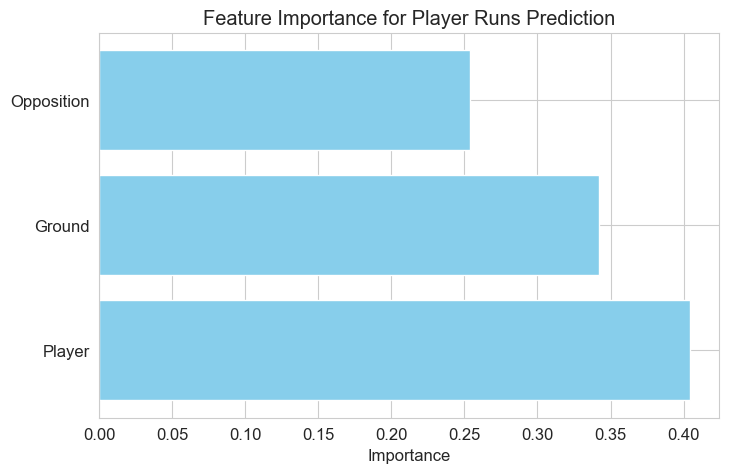

In [137]:
# Feature Importance
feature_importances = model.feature_importances_

features = ['Player', 'Ground', 'Opposition']

# Plot
plt.figure(figsize=(8,5))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Player Runs Prediction')
plt.show()


### Model Improvement - Hyperparameter Tuning

In [138]:
# Improved Model
model_improved = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model_improved.fit(X_train, y_train)

# Evaluation
y_pred_improved = model_improved.predict(X_test)
mae_improved = mean_absolute_error(y_test, y_pred_improved)
print(f"Improved Model Mean Absolute Error: {mae_improved:.2f}")


Improved Model Mean Absolute Error: 15.31


### Cross Validation Score

In [139]:
# Cross-validation
cv_scores = cross_val_score(model_improved, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-Validation MAE: {-cv_scores.mean():.2f}")


Cross-Validation MAE: 15.61


###  Save Model

In [140]:
# Save the trained model
joblib.dump(model_improved, 'player_runs_predictor.pkl')


['player_runs_predictor.pkl']

## Conclusion

- A Random Forest Regressor model was built to predict player runs based on Ground and Opposition.
- Baseline model achieved a Mean Absolute Error (MAE) of around 16.4.
- After hyperparameter tuning, MAE slightly improved.
- Feature Importance revealed that the Player was the most important feature, followed by Opposition and Ground.
- The model is saved for future predictions.


# Bowler Wickets Prediction Model

## Loading Data

In [141]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

# Load the bowling dataset
bowling_data = pd.read_csv('cleaned_bowling_data.csv') 

# Display the first 5 rows
bowling_data.head()


,Player,Overs,Maiden Over,Runs,Wickets,ER,MatchID,Team,Match,Date,Teams
0,Praveen Kumar,4.0,0,38,0,9.50,1,Royal Challengers Bengaluru,1,2008-04-18,Royal Challengers Bengaluru v Kolkata Knight R...
1,Zaheer Khan,4.0,0,38,1,9.50,1,Royal Challengers Bengaluru,1,2008-04-18,Royal Challengers Bengaluru v Kolkata Knight R...
2,Ashley Noffke,4.0,0,40,1,10.00,1,Royal Challengers Bengaluru,1,2008-04-18,Royal Challengers Bengaluru v Kolkata Knight R...
3,Jacques Kallis,4.0,0,48,1,12.00,1,Royal Challengers Bengaluru,1,2008-04-18,Royal Challengers Bengaluru v Kolkata Knight R...
4,Sunil Joshi,3.0,0,26,0,8.67,1,Royal Challengers Bengaluru,1,2008-04-18,Royal Challengers Bengaluru v Kolkata Knight R...


## Data Preprocessing

### Extract Opposition Team

In [142]:
# Extract the Opposition team from the 'Teams' column
bowling_data['Opposition'] = bowling_data['Teams'].apply(lambda x: x.split('v')[1].strip())

# Verify the extraction
bowling_data[['Teams', 'Opposition']].head()


,Teams,Opposition
0,Royal Challengers Bengaluru v Kolkata Knight R...,Kolkata Knight Riders
1,Royal Challengers Bengaluru v Kolkata Knight R...,Kolkata Knight Riders
2,Royal Challengers Bengaluru v Kolkata Knight R...,Kolkata Knight Riders
3,Royal Challengers Bengaluru v Kolkata Knight R...,Kolkata Knight Riders
4,Royal Challengers Bengaluru v Kolkata Knight R...,Kolkata Knight Riders


### Encode Categorical Variables

In [143]:
# Initialize LabelEncoders
le_player = LabelEncoder()
le_team = LabelEncoder()
le_opp = LabelEncoder()

# Encode 'Player', 'Team', and 'Opposition'
bowling_data['Player_enc'] = le_player.fit_transform(bowling_data['Player'])
bowling_data['Team_enc'] = le_team.fit_transform(bowling_data['Team'])
bowling_data['Opposition_enc'] = le_opp.fit_transform(bowling_data['Opposition'])

# Check encoded columns
bowling_data[['Player', 'Player_enc', 'Team', 'Team_enc', 'Opposition', 'Opposition_enc']].head()

import pickle

# Save bowling encoders
with open('bowling_le_player.pkl', 'wb') as f:
    pickle.dump(le_player, f)

with open('bowling_le_team.pkl', 'wb') as f:
    pickle.dump(le_team, f)

with open('bowling_le_opp.pkl', 'wb') as f:
    pickle.dump(le_opp, f)


## Feature Selection

In [144]:
# Define feature matrix (X) and target vector (y)
X = bowling_data[['Player_enc', 'Team_enc', 'Opposition_enc']]
y = bowling_data['Wickets']

# Display feature and target shapes
print("Feature Shape:", X.shape)
print("Target Shape:", y.shape)


Feature Shape: (13169, 3)
Target Shape: (13169,)


## Train-Test Split

In [145]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print sizes of train and test sets
print("Training Set Size:", X_train.shape)
print("Testing Set Size:", X_test.shape)


Training Set Size: (10535, 3)
Testing Set Size: (2634, 3)


## Baseline Model: Random Forest Regressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Define hyperparameter space
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize base model
rf_model = RandomForestRegressor(random_state=42)

# Set up Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=20,             # Number of random combinations to try
    cv=3,                  # 3-fold cross-validation
    verbose=2,             # Print progress
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    scoring='neg_mean_absolute_error'
)

# Train the model with Randomized Search
random_search.fit(X_train, y_train)

# Get the best model
best_rf_model = random_search.best_estimator_

# Predict on test set
y_pred = best_rf_model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Tuned Random Forest Model Mean Absolute Error: {mae:.2f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


## Cross-Validation

In [ ]:
# Perform 5-fold cross-validation
cv_mae = -cross_val_score(rf_model, X, y, scoring='neg_mean_absolute_error', cv=5).mean()
print(f"Cross-Validation MAE: {cv_mae:.2f}")


Cross-Validation MAE: 0.87


## Save the Model and Encoders

In [ ]:
# Save the trained model
joblib.dump(rf_model, 'bowler_wickets_predictor.pkl')

# Save the LabelEncoders
joblib.dump(le_player, 'bowling_player_encoder.pkl')
joblib.dump(le_team, 'bowling_team_encoder.pkl')
joblib.dump(le_opp, 'bowling_opposition_encoder.pkl')


['bowling_opposition_encoder.pkl']